# Prediction of Durham Daily Weather for 2020

## Introduction

The data set contains the daily temperature record taken at the Durham Observatory from 1901-2019. 
The daily temperature is calculated as the mean of the minimun and maximum temperature of that day.

## Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pmdarima import model_selection
from pmdarima import preprocessing

from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Read and process raw data 

In [2]:
yearfirst = 1901
yearlast  = 2019
leapyears = np.arange(1904,2021,4)

# Number of years of data 
n_years = yearlast - yearfirst + 1

# Every 4 years = 1461 records
step = 1461

# Read data
data = pd.read_csv('durhamtemp_1901_2019.csv', header=0).dropna(how='all')

# Rename columns - Av temp
data = data.rename(columns={'Av temp': 'Avgtemp'})

# Process data - convert date to datetime 
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# # Process data - convert date to numeric 
# data['Date'] = data['Datetime'].apply(lambda x: int(x.strftime('%Y%m%d')))

# Process data - add day of year 
data['Dayofyear'] = data['Date'].dt.dayofyear

n_records = len(data)

print(f'Expected number of records : {int(n_years/4*step)}')
print(f'Actual number of records   : {n_records}')

print(data.head(1))
print(data.tail(1))


Expected number of records : 43464
Actual number of records   : 43464
     Year  Month  Day       Date  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
0  1901.0    1.0  1.0 1901-01-01    0.0      2.1   3.5   0.6          1
         Year  Month   Day       Date  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
43463  2019.0   12.0  31.0 2019-12-31    0.2      2.1   5.6  -1.5        365


## Choose the data we want to work with

There are 119 years worth of data. However we will only work with the last N years 

In [3]:
# Number of years of data to work with - must be (a multiple of 4)-1 
# 119 to use all data
N = 119

print('Full set of data :\n')
print(data.head(1))
print(data.tail(1))


# Calculate years to remove
y = n_years-N # N=119 to keep all data
n = y/4 # 100/4 to remove 100 years leaving 2001-2019 

yearstart = yearfirst + y
yearend = yearlast

# Create a timeseries dataset with only the datetime, day of year, and temperature columns
data_wkg = data[['Date','Dayofyear','Avgtemp']][int(step*n):]

# Add index i as a columns
data_wkg.reset_index(inplace=True)
data_wkg['i'] = data_wkg.index

# Set Date as the index with daily frequency
data_wkg.set_index('Date', inplace=True)
data_wkg.index.freq = 'd'

print(f'\nData being used : {yearstart}-{yearend}:\n')
print(data_wkg.head(1))
print(data_wkg.tail(1))


Full set of data :

     Year  Month  Day       Date  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
0  1901.0    1.0  1.0 1901-01-01    0.0      2.1   3.5   0.6          1
         Year  Month   Day       Date  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
43463  2019.0   12.0  31.0 2019-12-31    0.2      2.1   5.6  -1.5        365

Data being used : 1901-2019:

            index  Dayofyear  Avgtemp  i
Date                                    
1901-01-01      0          1      2.1  0
            index  Dayofyear  Avgtemp      i
Date                                        
2019-12-31  43463        365      2.1  43463


In [4]:
data_wkg.describe()

index     Dayofyear       Avgtemp             i
count  43464.000000  43464.000000  43464.000000  43464.000000
mean   21731.500000    183.122101      8.722577  21731.500000
std    12547.120387    105.438029      5.096972  12547.120387
min        0.000000      1.000000     -9.000000      0.000000
25%    10865.750000     92.000000      4.800000  10865.750000
50%    21731.500000    183.000000      8.700000  21731.500000
75%    32597.250000    274.000000     12.800000  32597.250000
max    43463.000000    366.000000     24.400000  43463.000000

## Initial analysis of data

In [5]:
# Use a consisteNt figsize
fgsz=(24,12)

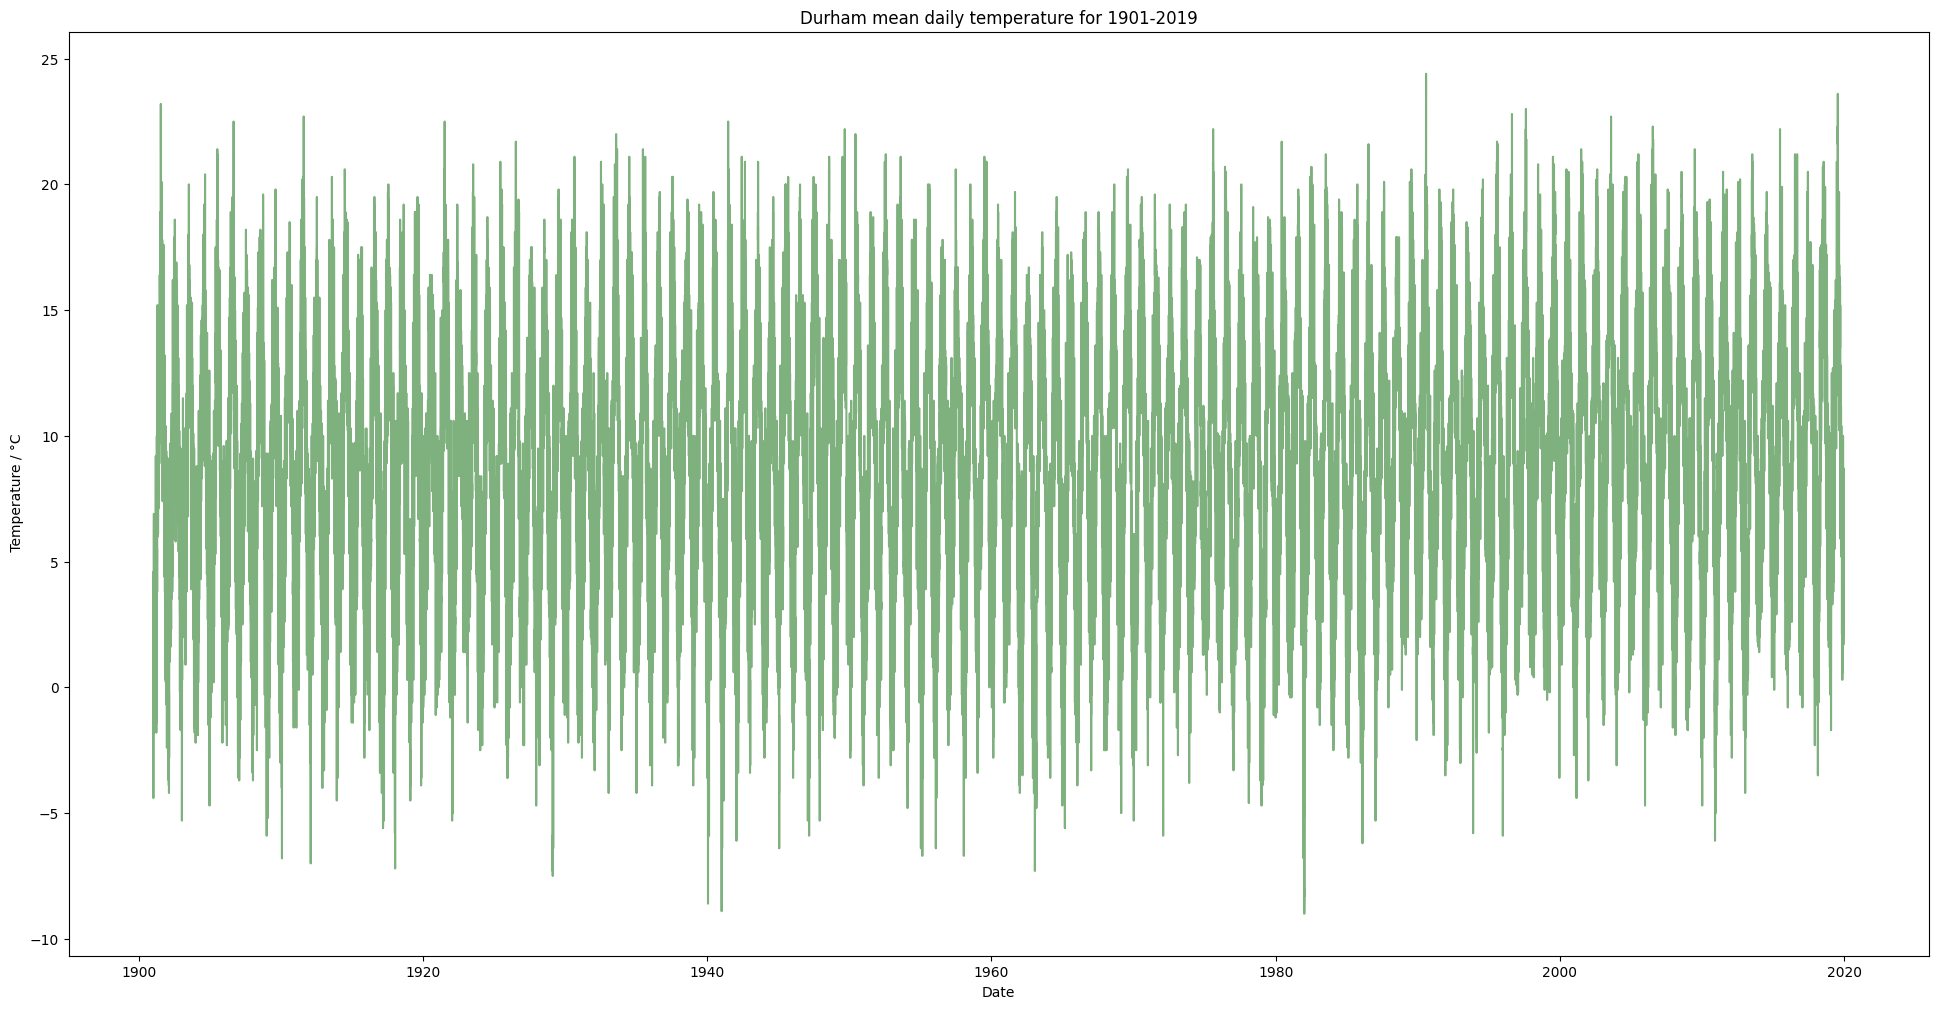

In [6]:
plt.figure(figsize=fgsz)
plt.plot(data_wkg.index.to_numpy(), data_wkg['Avgtemp'].to_numpy(), alpha=0.5, color='darkgreen')
plt.title(f'Durham mean daily temperature for {yearstart}-{yearend}')
plt.xlabel('Date')
plt.ylabel(' Temperature / °C')
plt.show()
 

Note -Plot demostrates seasonality. The temperature data has a clear seasonlity component. Higher temperatures in summers, lower temperatures in winters. 

In [7]:
# 14-day moving average

fg, ax = plt.subplots(1, 1, figsize=fgsz)
ma = data_wkg.Avgtemp.rolling(window=14).mean()
# Plot from 2015
plot_from='2015'
data_wkg.Avgtemp[plot_from:].plot(color='lightblue', label='Observed')
ma[plot_from:].plot(color='blue', label='14-day moving average')
plt.title(f'14-day moving average of Durham mean daily temperature for {plot_from}-{yearend}')
plt.xlabel('Date')
plt.ylabel(' Temperature / °C')
plt.legend()
plt.show()


In [8]:
#d dates=None
daysofyear=data_wkg.Dayofyear.to_numpy()
temps=data_wkg.Avgtemp.to_numpy()

doymean = data_wkg.groupby(['Dayofyear']).mean()['Avgtemp']

plt.figure(figsize=fgsz)

# Loop through the specified years plotting temp vs doy
s = e = 0
for i in range(yearstart,yearend,1):
    if i in leapyears:
        e += 366
    else:
        e += 365
    plt.plot(daysofyear[s:e], temps[s:e], alpha=0.5)
    s = e
    # if i > yearstart+2:
    #     break

doymean.plot(alpha=1, linewidth=3, color='darkgreen', label='Mean')

plt.title(f'Durham daily temperature by day of year for {yearstart}-{yearend}')
plt.xlabel('Day of year')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()

Note - Use above image to demostrate variabilty of temperatures within a day of the year (Jan 1 = day 1). Even though the overall seasonality can be seen. 

In [9]:
# Plot mean of Durham daily temperature by day of year
plt.figure(figsize=fgsz)
doymean.plot(alpha=0.5, color='darkgreen')
plt.title(f'Mean of Durham daily temperature by day of year for {yearstart}-{yearend}')
plt.xlabel('Day of year')
plt.ylabel(' Mean Daily Temperature / °C')
plt.show()

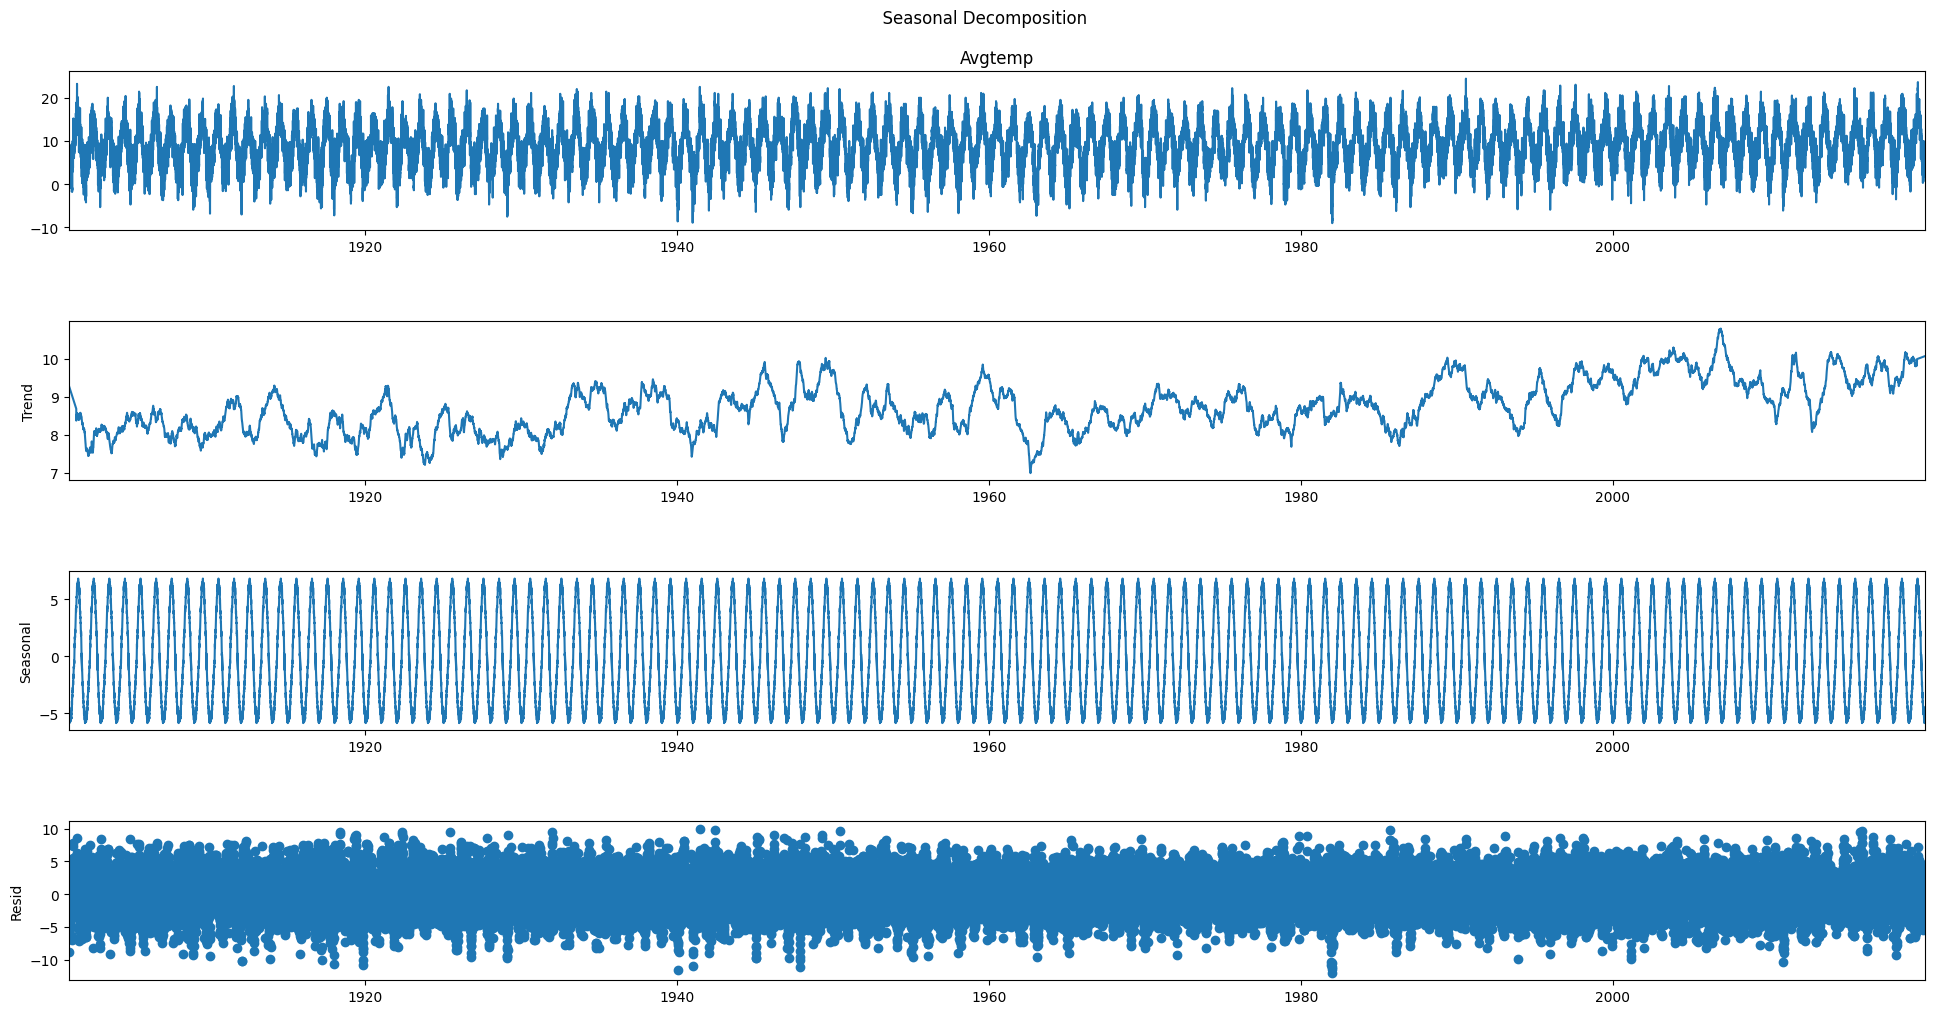

In [10]:
# Plot seasonal decomposition
decomposition = seasonal_decompose(data_wkg.Avgtemp, model='additive', extrapolate_trend='freq', period=365)
fg = decomposition.plot()
fg.set_size_inches(fgsz[0]*.9,fgsz[1]*.9)
fg.suptitle('                                  Seasonal Decomposition')
plt.show()

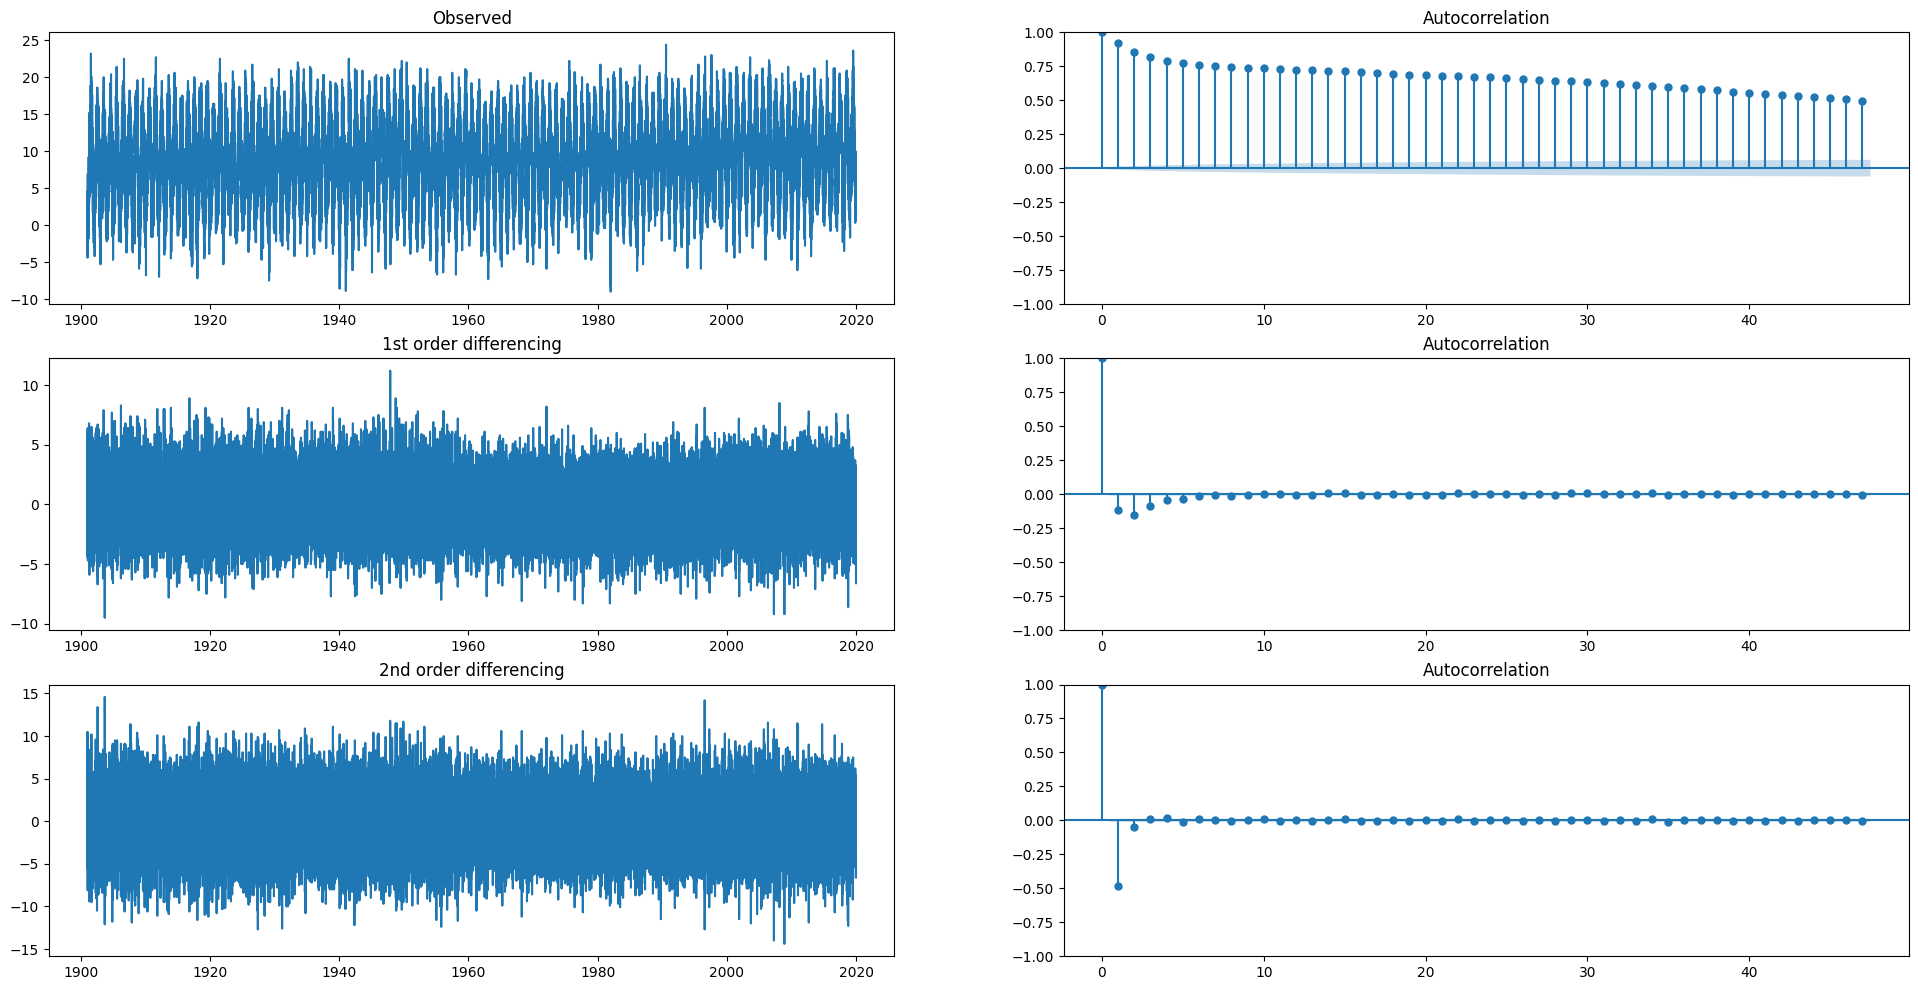

In [11]:
# Differencing

# Observed
fg, ax = plt.subplots(3, 2, figsize=fgsz)
ax[0, 0].plot(data_wkg.Avgtemp)
ax[0, 0].set_title('Observed')
plot_acf(data_wkg.Avgtemp, ax=ax[0, 1])

# 1st order
ax[1, 0].plot(data_wkg.Avgtemp.diff())
ax[1, 0].set_title('1st order differencing')
plot_acf(data_wkg.Avgtemp.diff().dropna(), ax=ax[1, 1])

# 2nd Order
ax[2, 0].plot(data_wkg.Avgtemp.diff().diff())
ax[2, 0].set_title('2nd order differencing')
plot_acf(data_wkg.Avgtemp.diff().diff().dropna(), ax=ax[2, 1])

plt.show()

In [12]:
doymean_days = np.arange(1,367)
# doymean_temps = np.array(data_wkg.groupby('Dayofyear')['Av temp'].mean())
doymean_temps2 = np.array(data_wkg.groupby('Dayofyear')['Avgtemp'].median())
doymean_temps_uq = np.array(data_wkg.groupby('Dayofyear')['Avgtemp'].quantile(q=0.75))-doymean_temps2
doymean_temps_lq = doymean_temps2 - np.array(data.groupby('Dayofyear')['Avgtemp'].quantile(q=0.25))
doymean_temps_error = [doymean_temps_lq, doymean_temps_uq]

plt.figure(figsize=fgsz)
plt.errorbar(doymean_days, doymean_temps2, yerr=doymean_temps_error, fmt='o')
plt.title(f'Day of year median of Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel('Day of year (Jan 1st = day 1)')
plt.ylabel('Daily Temperature / °C')
plt.show()

In [13]:
x = data_wkg.i.to_numpy()
y = data_wkg.Avgtemp.to_numpy()

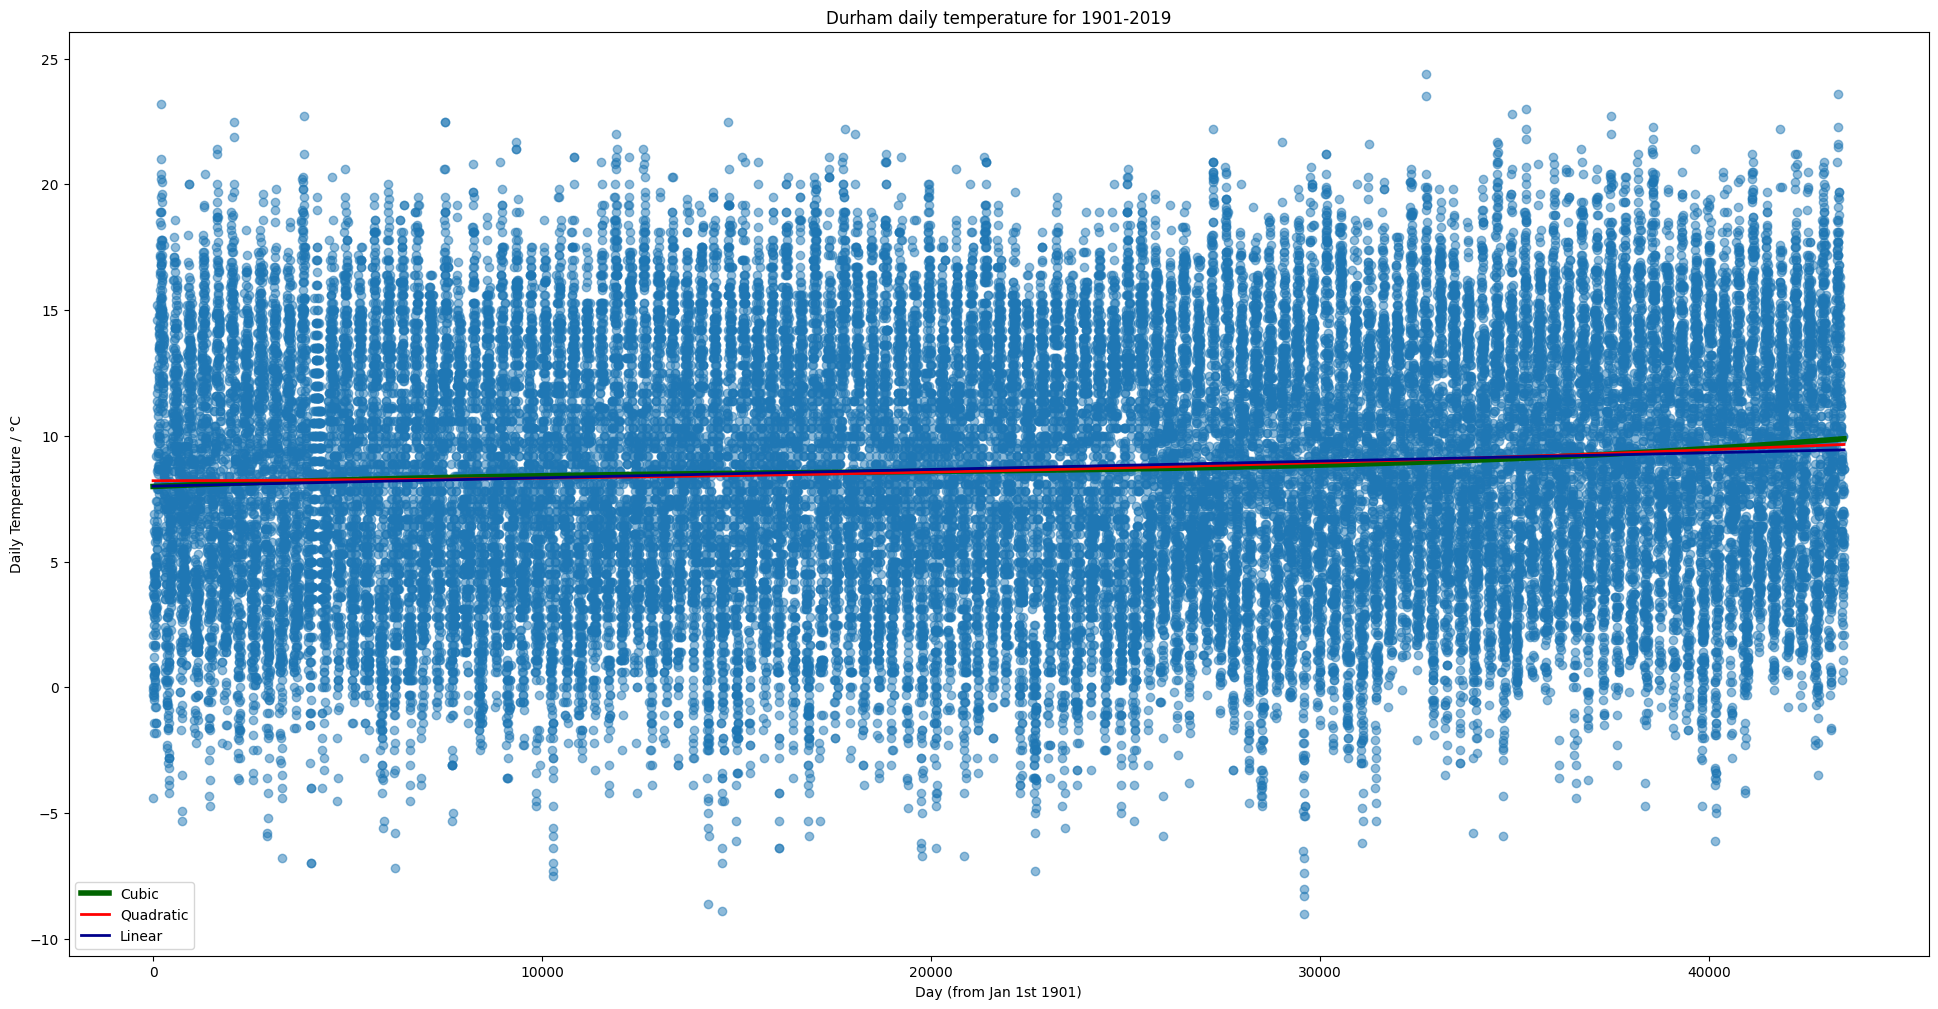

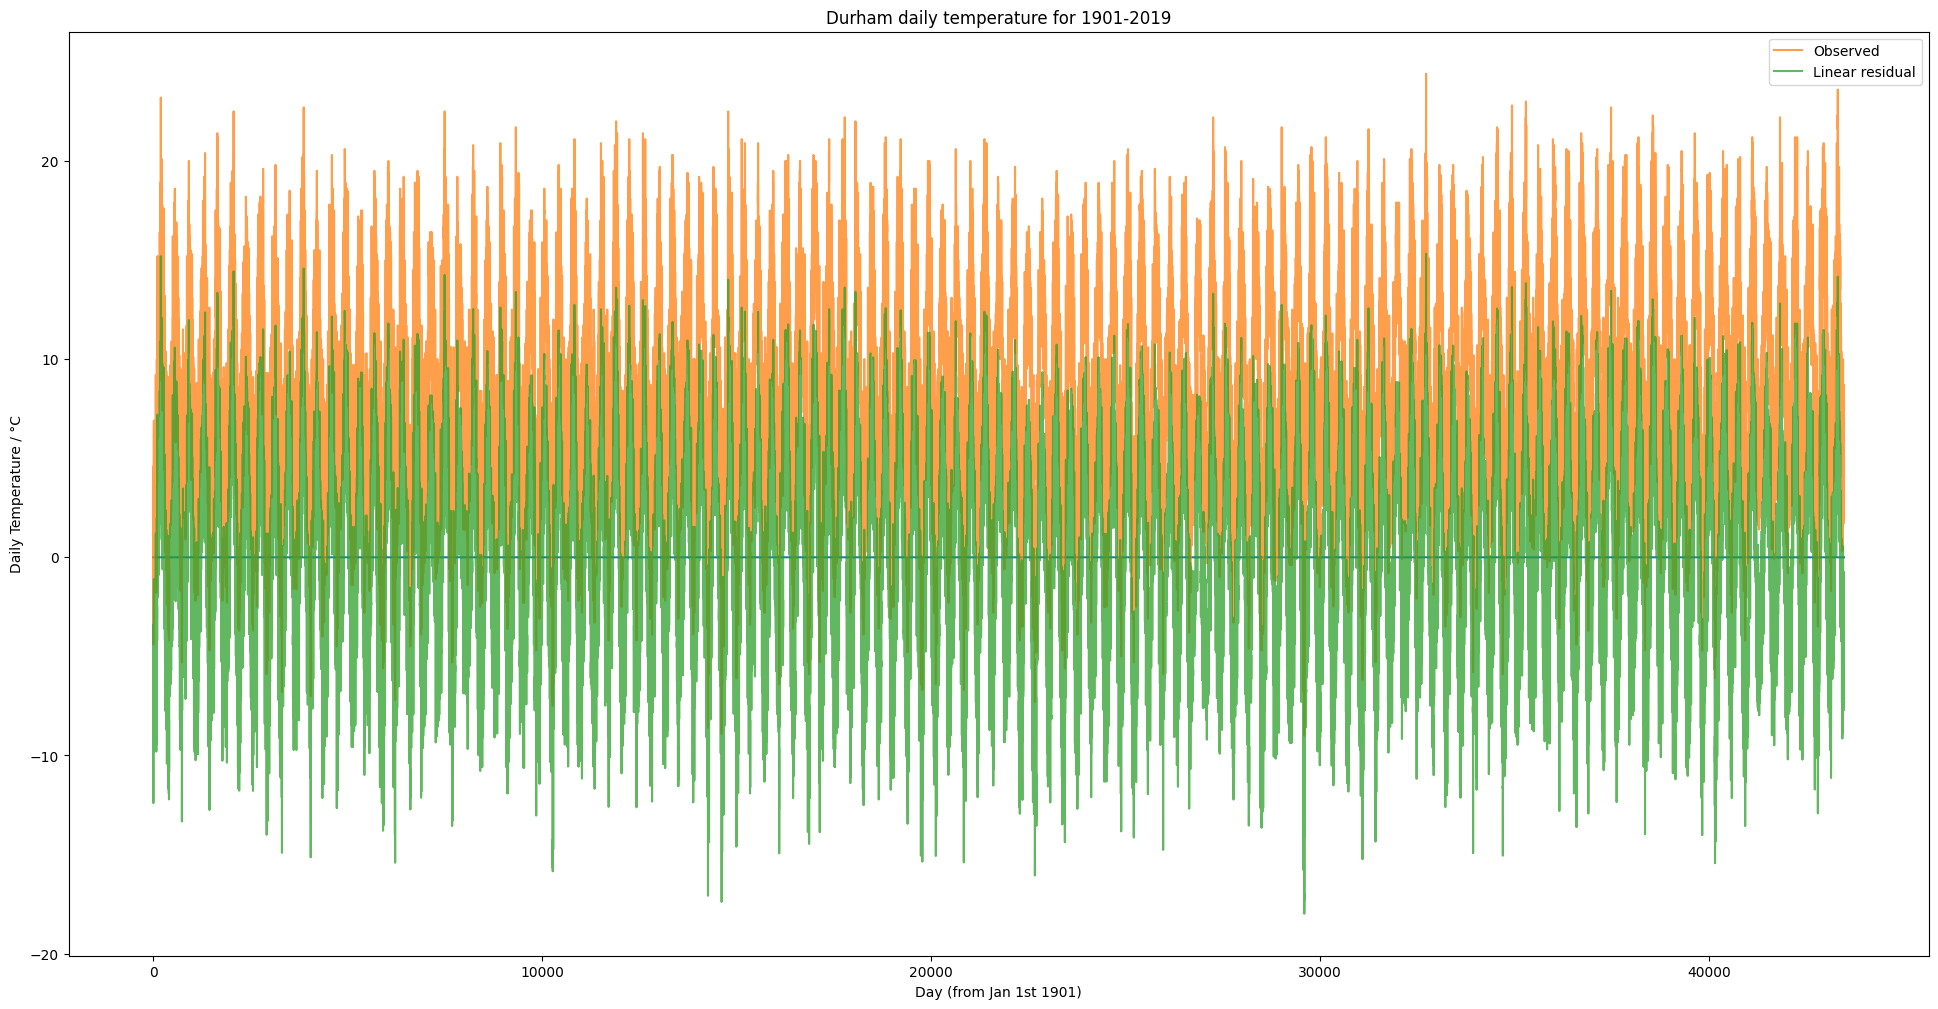

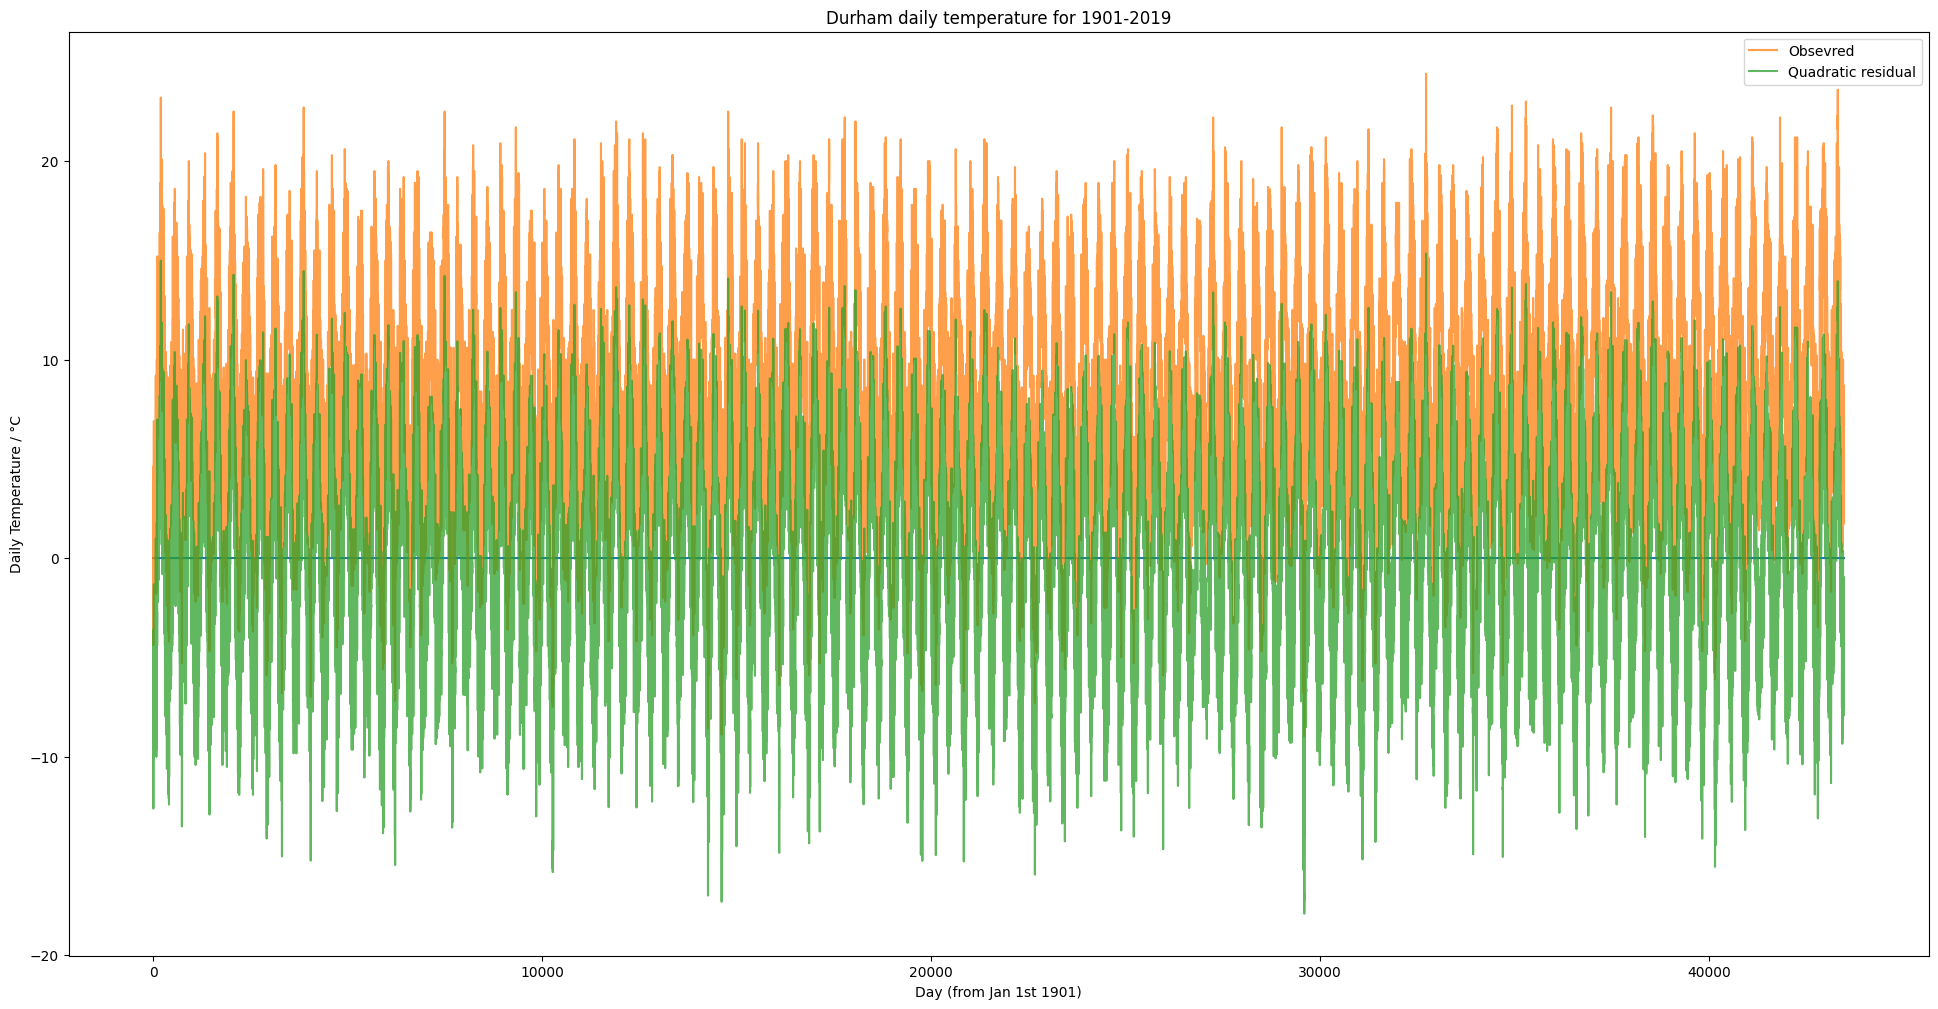

In [14]:
poly1 = PolynomialFeatures(degree=1)
poly2 = PolynomialFeatures(degree=2)
poly3 = PolynomialFeatures(degree=3)

x_lnr = poly1.fit_transform(data_wkg.i.to_numpy().reshape(-1,1))
x_qud = poly2.fit_transform(data_wkg.i.to_numpy().reshape(-1,1))
x_cbc = poly3.fit_transform(data_wkg.i.to_numpy().reshape(-1,1))

res_lnr = sm.OLS(data_wkg.Avgtemp.to_numpy().reshape(-1,1), x_lnr).fit()
res_qud = sm.OLS(data_wkg.Avgtemp.to_numpy().reshape(-1,1), x_qud).fit()
res_cbc = sm.OLS(data_wkg.Avgtemp.to_numpy().reshape(-1,1), x_cbc).fit()

plt.figure(figsize=fgsz)
plt.scatter(x, y, alpha=0.5)
plt.plot(x, res_cbc.fittedvalues, linewidth=4, color='darkgreen', label='Cubic')
plt.plot(x, res_qud.fittedvalues, linewidth=2, color='red', label='Quadratic')
plt.plot(x, res_lnr.fittedvalues, linewidth=2, color='darkblue', label='Linear')
plt.title(f'Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel(f'Day (from Jan 1st {yearstart})')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()

# print(res_lnr.resid)

plt.figure(figsize=fgsz)
plt.plot(x, np.zeros(len(x)), alpha=1)
plt.plot(x, y, alpha=0.75, label='Observed')
plt.plot(x, res_lnr.resid, alpha=0.75, label='Linear residual')
plt.title(f'Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel(f'Day (from Jan 1st {yearstart})')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()

plt.figure(figsize=fgsz)
plt.plot(x, np.zeros(len(x)), alpha=1)
plt.plot(x, y, alpha=0.75, label='Obsevred')
plt.plot(x, res_qud.resid, alpha=0.75, label='Quadratic residual')
plt.title(f'Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel(f'Day (from Jan 1st {yearstart})')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()

plt.figure(figsize=fgsz)
plt.plot(x, np.zeros(len(x)), alpha=1)
plt.plot(x, y, alpha=0.75, label='Onserved')
plt.plot(x, res_cbc.resid, alpha=0.75, label='Cubic residual')
plt.title(f'Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel(f'Day (from Jan 1st {yearstart})')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()


In [15]:
# Process data - add day of year 
data_wkg['LinearResidual'] = res_lnr.resid

doy_linear_residual = (data_wkg.groupby('Dayofyear')['LinearResidual'].median())
median_residual = data_wkg.Dayofyear.apply(lambda doy: doy_linear_residual.iloc[doy-1])

data_wkg['BestResidual']  = data_wkg.LinearResidual - median_residual

plt.figure(figsize=fgsz)
plt.plot(x, np.zeros(len(x)), alpha=1, label='Observed')
plt.plot(x, y, alpha=0.75, label='Best residual')
plt.plot(x, data_wkg['BestResidual'].to_numpy(), alpha=0.75)
plt.title(f'Best residual - Durham daily temperature for {yearstart}-{yearend}')
plt.xlabel(f'Day (from Jan 1st {yearstart})')
plt.ylabel('Daily Temperature / °C')
plt.legend()
plt.show()

## Assess possible models

In [16]:
# Generate the combinations of p,d,q for the models we wish to assess 

p = range(1,4)
d = range(1,2)
q = range(1,4)

pdq = list(itertools.product(p, d, q))

print(pdq)

[(1, 1, 1), (1, 1, 2), (1, 1, 3), (2, 1, 1), (2, 1, 2), (2, 1, 3), (3, 1, 1), (3, 1, 2), (3, 1, 3)]


### Get the best model and Fourier terms k-value

In [17]:
# Use fourier terms for seasonality

best_aic = np.inf
best_k = None
best_order = None
best_model = None

# Find the 'best' model including k-value
# Changed to run more quickly bu still demonstart slection of 'best' model (originally ran k=1-12)
for k in range(3,7):
    fterms = preprocessing.FourierFeaturizer(365.25, k=k)
    fdata, X = fterms.fit_transform(data_wkg.Avgtemp)
    X['Date'] = fdata.index
    X.set_index(X['Date'], inplace=True)
    X.index.freq = 'd'
    X = X.drop(columns=['Date'])

    for order in pdq:
        # print(f'Assessing k {k}, ARIMA {param}')
        candidate_model = ARIMA(data_wkg.Avgtemp, order=order, enforce_stationarity=False, enforce_invertibility=False, exog=X)
        results = candidate_model.fit(method_kwargs={"warn_convergence": False})
        print(f'Result for k={k} ARIMA {order} : AIC={results.aic} AICc={results.aicc}')
        if results.aic < best_aic:
            print(f'- updating best model')
            best_aic = results.aic
            best_k = k
            best_order = order
            best_model = candidate_model


Result for k=3 ARIMA (1, 1, 1) : AIC=179715.00111727032 AICc=179715.00525986773
- updating best model
Result for k=3 ARIMA (1, 1, 2) : AIC=179647.48161039746 AICc=179647.48667380514
- updating best model
Result for k=3 ARIMA (1, 1, 3) : AIC=179597.79855786765 AICc=179597.80463423656
- updating best model
Result for k=3 ARIMA (2, 1, 1) : AIC=179657.93911860813 AICc=179657.94418189928
Result for k=3 ARIMA (2, 1, 2) : AIC=179631.0860599353 AICc=179631.09213616437
Result for k=3 ARIMA (2, 1, 3) : AIC=179610.73471576296 AICc=179610.7418970915
Result for k=3 ARIMA (3, 1, 1) : AIC=2675254.89287382 AICc=2675254.898950049
Result for k=3 ARIMA (3, 1, 2) : AIC=179547.61468147035 AICc=179547.62186263362
- updating best model
Result for k=3 ARIMA (3, 1, 3) : AIC=179608.26089715175 AICc=179608.26927556124
Result for k=4 ARIMA (1, 1, 1) : AIC=179708.91087199017 AICc=179708.91694807936
Result for k=4 ARIMA (1, 1, 2) : AIC=179640.60879056185 AICc=179640.6159717251
Result for k=4 ARIMA (1, 1, 3) : AIC=1

In [18]:
print(f'Best model acheived with k={best_k} order={best_order}')

Best model acheived with k=6 order=(3, 1, 2)


## Test the 'best' model by predicting 2019

In [19]:
# Split the data 
train, test = model_selection.train_test_split(data_wkg, train_size=len(data_wkg.Avgtemp)-365)

print(train.head(5))
print(test.head(5))

            index  Dayofyear  Avgtemp  i  LinearResidual  BestResidual
Date                                                                  
1901-01-01      0          1      2.1  0       -5.901597     -0.488219
1901-01-02      1          2      4.0  1       -4.001630      0.817775
1901-01-03      2          3      3.0  2       -5.001663      0.436329
1901-01-04      3          4      3.7  3       -4.301696      1.329885
1901-01-05      4          5     -0.3  4       -8.301730     -2.709293
            index  Dayofyear  Avgtemp      i  LinearResidual  BestResidual
Date                                                                      
2019-01-01  43099          1      7.0  43099       -2.431481      2.981896
2019-01-02  43100          2      4.5  43100       -4.931515     -0.112110
2019-01-03  43101          3      0.8  43101       -8.631548     -3.193556
2019-01-04  43102          4      3.8  43102       -5.631581      0.000000
2019-01-05  43103          5      5.7  43103       -3

In [20]:
# Test our model by predicting 2019

# Use fourier terms for seasonality
# Overidde best values to test other scenarios
k = best_k
order = best_order

fterms = preprocessing.FourierFeaturizer(365.25, k=k)

train_data, test_X = fterms.fit_transform(train.Avgtemp)
test_X['Date'] = train_data.index
test_X.set_index(test_X['Date'], inplace=True)
test_X.index.freq = 'd'
test_X = test_X.drop(columns=['Date'])

test_data, test_Xf = fterms.fit_transform(train.Avgtemp, n_periods=365)

test_Xf['Date'] = np.arange('2019-01-01', '2020-01-01', dtype='datetime64[D]')
test_Xf.set_index(test_Xf['Date'], inplace=True)
test_Xf.index.freq = 'd'
test_Xf = test_Xf.drop(columns=['Date'])

# Create and fit the model, get prediction for 2019

test_mdl = ARIMA(train_data, order=order, enforce_stationarity=False, enforce_invertibility=False, exog=test_X)
test_res = test_mdl.fit(method_kwargs={"warn_convergence": False})
test_pr = test_res.get_prediction(start=pd.to_datetime('20140101'), end=pd.to_datetime('20191231'), dynamic=False, exog=test_Xf)


In [21]:
test_res.plot_diagnostics(figsize=fgsz)
plt.show()

In [22]:
# Plot comparison of test prediction and observed

fg, ax = plt.subplots(figsize=fgsz)
data_wkg.Avgtemp['2014':].plot(label='Observed', ax=ax)
test_pr.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(test_pr.conf_int().index, test_pr.conf_int().iloc[:, 0], test_pr.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Temperature / °C')
plt.title(f'Comparison of observed daily temperature to prediction for 2014-2019')
plt.legend()
plt.show()

In [23]:
MSE = np.square(test.Avgtemp-test_pr.predicted_mean).mean()
print(f'Mean Squared Error is {MSE}')

Mean Squared Error is 6.743766091852175


## Predict 2020

In [24]:
# Predicting 2020

# Use fourier terms for seasonality
# Overidde best values to test other scenarios
k = best_k
order = best_order

fterms = preprocessing.FourierFeaturizer(365.25, k=k)
i, X = fterms.fit_transform(data_wkg.Avgtemp)
X['Date'] = i.index
X.set_index(X['Date'], inplace=True)
X.index.freq = 'd'
X = X.drop(columns=['Date'])

i, Xf = fterms.fit_transform(data_wkg.Avgtemp, n_periods=366)

Xf['Date'] = np.arange('2020-01-01', '2021-01-01', dtype='datetime64[D]')
Xf.set_index(Xf['Date'], inplace=True)
Xf.index.freq = 'd'
Xf = Xf.drop(columns=['Date'])

# Predict 2020
best_mdl = ARIMA(data_wkg.Avgtemp, order=order, enforce_stationarity=False, enforce_invertibility=False, exog=X)
best_res = best_mdl.fit(method_kwargs={"warn_convergence": False})
best_pr = best_res.get_prediction(start=pd.to_datetime('20200101'), end=pd.to_datetime('20201231'), dynamic=False, exog=Xf)

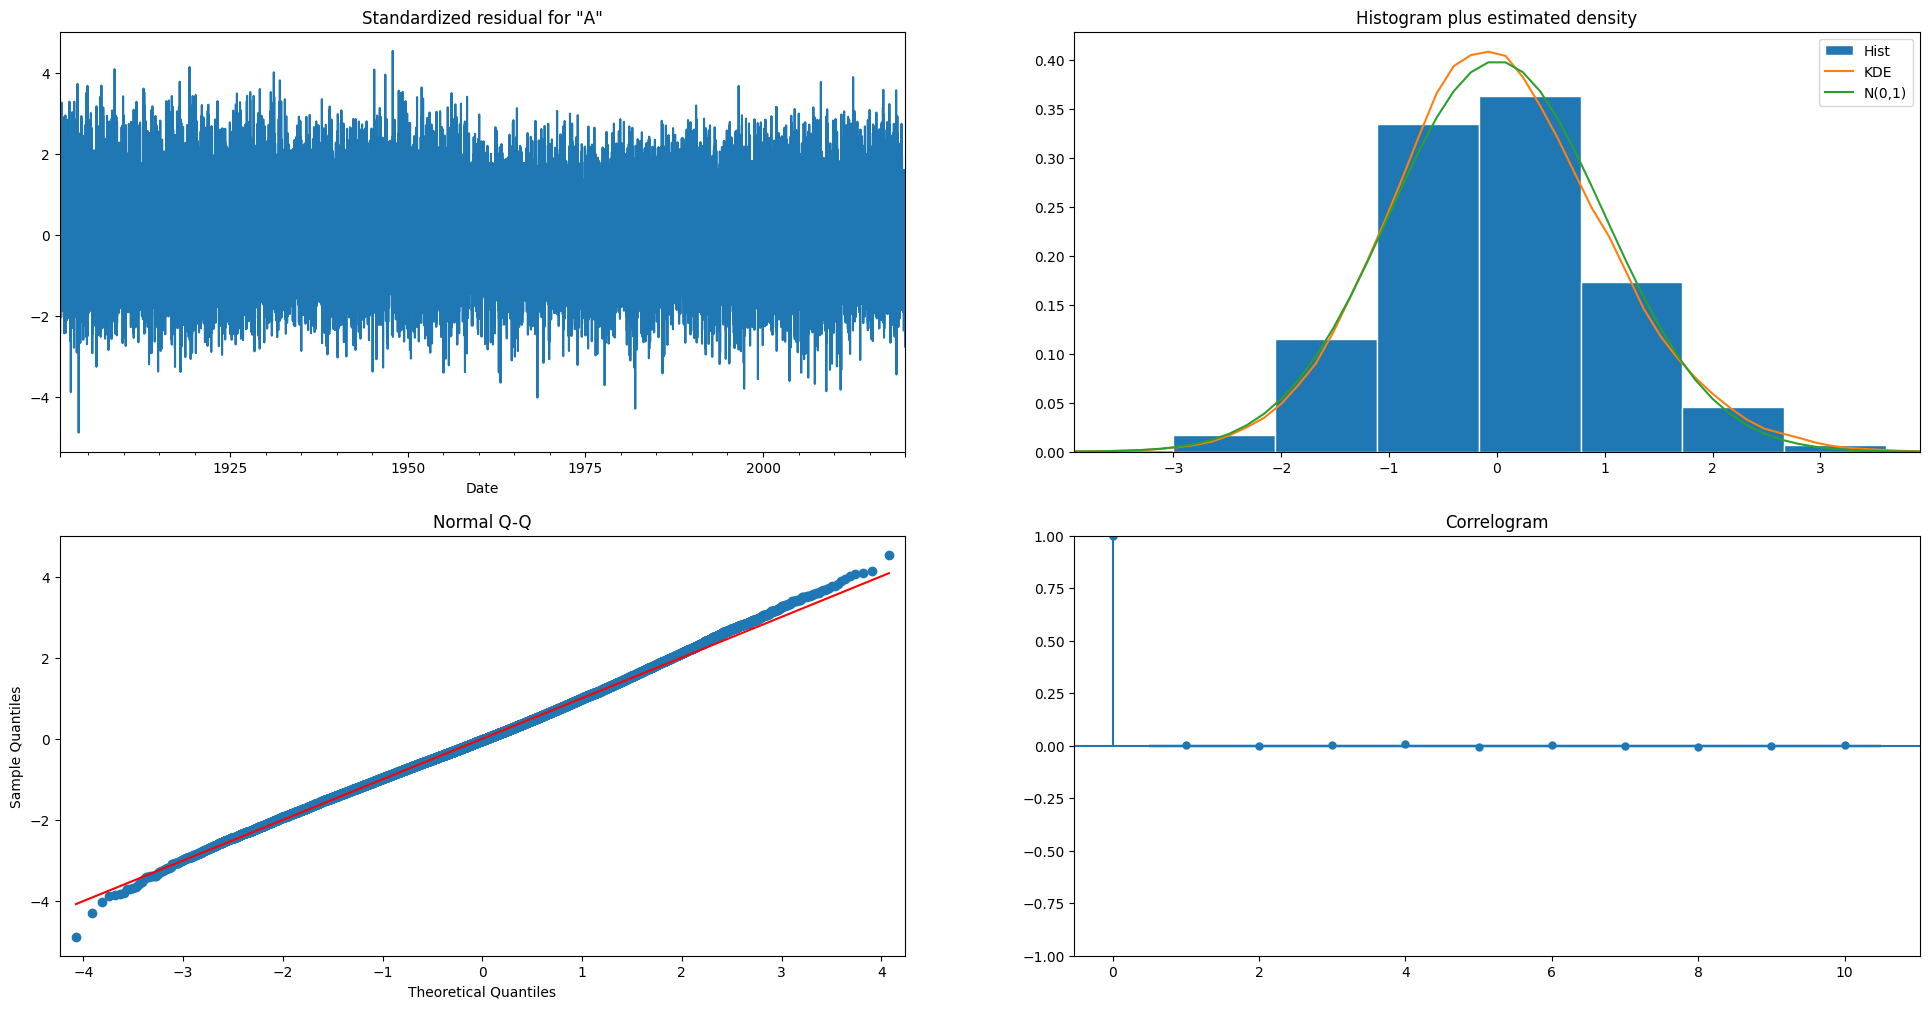

In [25]:
best_res.plot_diagnostics(figsize=fgsz)
plt.show()

In [26]:
# Create plot to compare prediction with observed

fg, ax = plt.subplots(figsize=fgsz)
data_wkg.Avgtemp['2014':].plot(label='Observed', ax=ax)
best_pr.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(best_pr.conf_int().index, best_pr.conf_int().iloc[:, 0], best_pr.conf_int().iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Temperature / °C')
plt.title(f'Observed daily temperature from 2014-2019 plus 2020 prediction')
plt.legend()
plt.show()

In [27]:
# Read 2020 data
data_2020 = pd.read_csv('durhamtemp_2020.csv', header=0).dropna(how='all')

# Rename columns - Av temp
data_2020 = data_2020.rename(columns={'Av temp': 'Avgtemp'})

# Process data - convert date to datetime 
data_2020['Date'] = pd.to_datetime(data_2020['Date'], format='%d/%m/%Y')

# # Process data - convert date to numeric 
# data['Date'] = data['Datetime'].apply(lambda x: int(x.strftime('%Y%m%d')))

# Process data - add day of year 
data_2020['Dayofyear'] = data_2020['Date'].dt.dayofyear

# Set Date as the index
data_2020.set_index('Date', inplace=True)

n_records_2020 = len(data_2020)

print(f'Number of records: {n_records_2020}')

print(data_2020.head(1))
print(data_2020.tail(1))

Number of records: 366
              Year  Month  Day  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
Date                                                                 
2020-01-01  2020.0    1.0  1.0    0.0      4.4   7.0   1.8          1
              Year  Month   Day  PPT.   Avgtemp  Tmax  Tmin  Dayofyear
Date                                                                  
2020-12-31  2020.0   12.0  31.0    3.8     0.95   4.1  -2.2        366


In [28]:
MSE = np.square(data_2020.Avgtemp-best_pr.predicted_mean).mean()
print(f'Mean Squared Error is {MSE}')

Mean Squared Error is 5.798449248409116


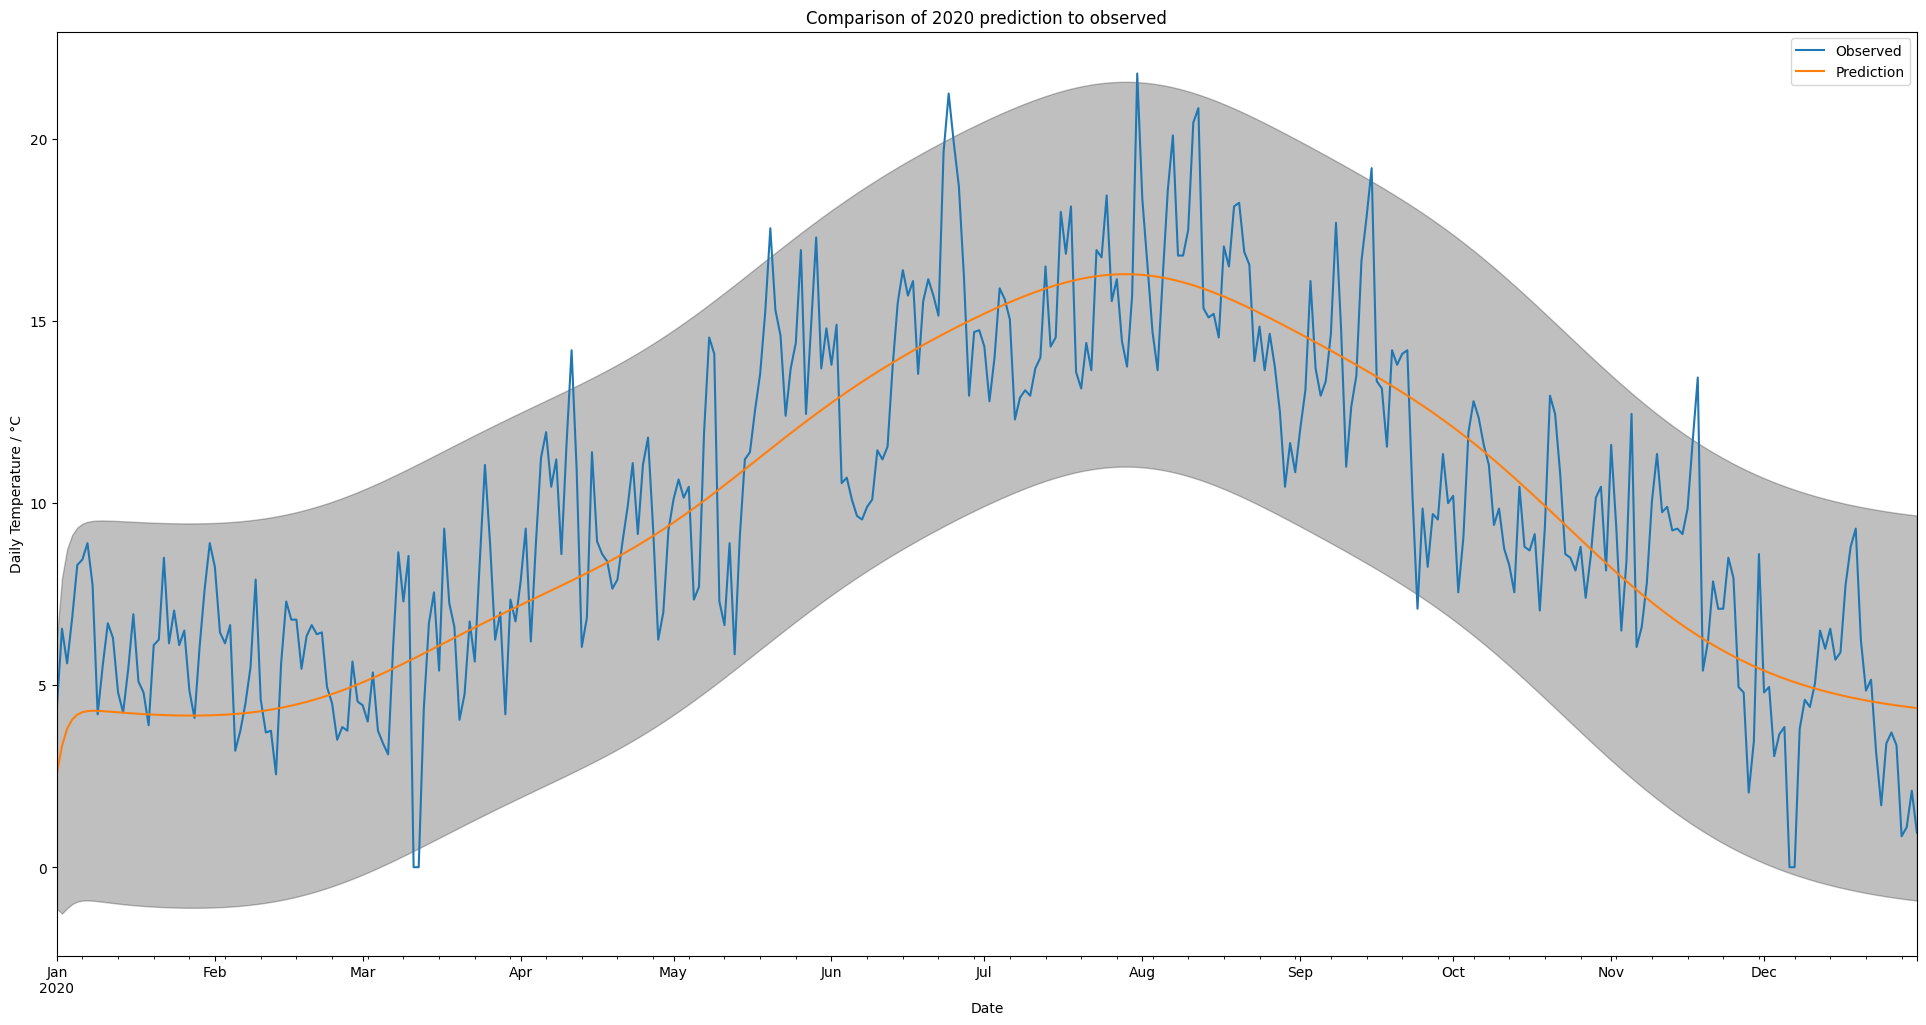

In [29]:
# Plot comparison of 2020 prediction and observed

fg, ax = plt.subplots(figsize=fgsz)
data_2020.Avgtemp.plot(label='Observed', ax=ax)
best_pr.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(best_pr.conf_int().index, best_pr.conf_int().iloc[:, 0], best_pr.conf_int().iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Temperature / °C')
plt.title(f'Comparison of 2020 prediction to observed')
plt.legend()
plt.show()

In [30]:
# Plot comparison of 2020 prediction, observed, and observed 14d MA

fg, ax = plt.subplots(figsize=fgsz)

# Actual
data_2020.Avgtemp.plot(label='Observed', ax=ax)
# 14-day moving average
ma=14
data_2020.Avgtemp.rolling(window=ma).mean().plot(label=f'Observed ({ma}-day moving average)', ax=ax)
# Prediction
best_pr.predicted_mean.plot(ax=ax, label='Prediction')
ax.fill_between(best_pr.conf_int().index, best_pr.conf_int().iloc[:, 0], best_pr.conf_int().iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Temperature / °C')
plt.title(f'Comparison of 2020 prediction to observed and observed {ma}-day moving average')
plt.legend()
plt.show()